In [1]:
import pandas
import datetime
import math
import os
import numpy
from scipy import signal, ndimage, stats
from scipy.optimize import curve_fit
from davitpy.models import *
from davitpy import utils
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
import seaborn as sns
from aacgmv2 import convert_mlt
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# Some constants
equTrghCutoffMLat = 40.
polTrghCutoffMLat = 70.
# We'll only look at NA continent, So we 
# choose the corresponding MLONS - 260, 20
mlonNAList = range( -100, 21, 2 )#range( -180, 181, 2 )#
# Some cutoffs to verify goodness of fit
cutoffKSPval = 0.7
cutoffKSDstat = 0.25
cutOffTrghMinUpper = 65.
cutOffTrghMinLower = 50.
cutOffPrcntErrorFit = 0.2 # 10%
cutOffLatCnt = 20
cutOffMinTECVal = 5.
cutoffUnqMlonCnt = 15.
cutOffPredEquTECMLAT = 45.
cutOffPredPolTECMLAT = 70.
# set variables for trough location filtering
trghLocMlonbinSize = 20
trghLocMlonbinCntCutoff = 0.2
cutOffGoodMlonBins = 2

In [3]:
def convert_to_datetime(row):
    currDateStr = str( int( row["dateStr"] ) )
#     return currDateStr
    if row["timeStr"] < 10:
        currTimeStr = "000" + str( int( row["timeStr"] ) )
    elif row["timeStr"] < 100:
        currTimeStr = "00" + str( int( row["timeStr"] ) )
    elif row["timeStr"] < 1000:
        currTimeStr = "0" + str( int( row["timeStr"] ) )
    else:
        currTimeStr = str( int( row["timeStr"] ) )
    return datetime.datetime.strptime( currDateStr\
                    + ":" + currTimeStr, "%Y%m%d:%H%M" )

selDT = datetime.datetime( 2011, 4, 9, 9, 0 )
anlyzCoords = 'mag'

In [4]:
inpColList = [ "dateStr", "timeStr", "Mlat",\
              "Mlon", "med_tec", "dlat", "dlon" ]
inpFile = "../data/tec-medFilt-20110409.txt"#"../../../../Desktop/tec-medFilt-20150409.txt"
medFiltTECDF = pandas.read_csv(inpFile, delim_whitespace=True,\
                                    header=None, names=inpColList)
medFiltTECDF["date"] = medFiltTECDF.apply( convert_to_datetime, axis=1 )
medFiltTECDF.head()

,dateStr,timeStr,Mlat,Mlon,med_tec,dlat,dlon,date
0,20110409,10,11.0,32.0,7.7,1.0,2.0,2011-04-09 00:10:00
1,20110409,10,11.0,34.0,8.7,1.0,2.0,2011-04-09 00:10:00
2,20110409,10,11.0,36.0,9.3,1.0,2.0,2011-04-09 00:10:00
3,20110409,10,11.0,66.0,14.3,1.0,2.0,2011-04-09 00:10:00
4,20110409,10,11.0,68.0,14.7,1.0,2.0,2011-04-09 00:10:00


In [5]:
print medFiltTECDF["timeStr"].unique()

[  10   20   25   30   35   40   45   55  105  110  115  120  125  130  140
  150  155  200  205  210  215  225  235  240  245  250  255  300  310  320
  325  330  335  340  345  355  405  410  415  420  425  430  440  450  455
  500  505  510  515  525  535  540  545  550  555  600  610  620  625  630
  635  640  645  655  705  710  715  720  725  730  740  750  755  800  805
  810  815  825  835  840  845  850  855  900  910  920  925  930  935  940
  945  955 1005 1010 1015 1020 1025 1030 1040 1050 1055 1100 1105 1110 1115
 1125 1135 1140 1145 1150 1155 1200]


In [6]:
# Analyze the selected time
selTecDF = medFiltTECDF[ medFiltTECDF["date"] == selDT ].reset_index(drop=True)
selTecDF.head()

,dateStr,timeStr,Mlat,Mlon,med_tec,dlat,dlon,date
0,20110409,900,11.0,32.0,10.8,1.0,2.0,2011-04-09 09:00:00
1,20110409,900,11.0,34.0,11.9,1.0,2.0,2011-04-09 09:00:00
2,20110409,900,11.0,70.0,33.0,1.0,2.0,2011-04-09 09:00:00
3,20110409,900,11.0,72.0,34.0,1.0,2.0,2011-04-09 09:00:00
4,20110409,900,11.0,74.0,34.8,1.0,2.0,2011-04-09 09:00:00


In [7]:
def gauss_function(x, a, x0, sigma):
    return a*numpy.exp(-(x-x0)**2/(2*sigma**2))

In [8]:
BndMlonArr = []
BndEquMlatArr = []
BndPolMlatArr = []
minTecMlatArr = []
minTecValArr = []
BndEquTecValArr = []
BndPolTecValArr = []
currTimeArr = []
selMlonList = [ 300., 320., 20., 80. ]
for ind, sMlon in enumerate(mlonNAList):
    if sMlon < 0.:
        sMlon = sMlon + 360.
    selMlonDF = selTecDF[ (selTecDF["Mlon"] == sMlon) &\
                          (selTecDF["Mlat"] >= equTrghCutoffMLat) &\
                          (selTecDF["Mlat"] <= polTrghCutoffMLat)]
    # If no significant number of values are found discard
    if len( selMlonDF["med_tec"].values ) < 5.:
        continue
    tecGaussFitArr = numpy.max( selMlonDF["med_tec"].values ) - selMlonDF["med_tec"].values
    mlatPltArr = numpy.arange(equTrghCutoffMLat-20, polTrghCutoffMLat+20)
    try:
        popt, pcov = curve_fit(gauss_function, selMlonDF["Mlat"].values,\
                               tecGaussFitArr, p0 = [2, 52., 1.])
    except:
#         print "failed fit at MLON-->", sMlon
        continue
    fwhmEqu = popt[1] - popt[2]#*2.355/2.
    fwhmPol = popt[1] + popt[2]#*2.355/2.
    tecValFwhmEqu = gauss_function(fwhmEqu, *popt)
    tecValFwhmPol = gauss_function(fwhmPol, *popt)
    # Test goodness of fit
    ksTestTecArr = numpy.array( [ gauss_function(l, *popt)\
                                for l in selMlonDF["Mlat"].values.tolist() ] )
    ksDStat, ksPVal = stats.ks_2samp( tecGaussFitArr, ksTestTecArr )
    # we setup a few conditions to discard bad fits
    # 1) location of trough min should be between 45 nad 65 MLAT
    if ((popt[1] > cutOffTrghMinUpper)\
            | (popt[1] < cutOffTrghMinLower)):
        continue
    # 2) if percent error in any of fit parameters is more 
    # than 10 % (cutoff) then skip
    if ( ( pcov[0,0]**0.5/popt[0] > cutOffPrcntErrorFit  ) \
        | ( pcov[1,1]**0.5/popt[1] > cutOffPrcntErrorFit  ) \
        | ( pcov[2,2]**0.5/popt[2] > cutOffPrcntErrorFit  ) ):
        continue
    # 3) Number of latitudes should be greater than 20.
    if len( selMlonDF["Mlat"].values ) < cutOffLatCnt:
        continue
    # 4) If p-val from the KS TEST is low discard
    # or if KS Stat is high discard
    if ksPVal < cutoffKSPval:
        continue
    if ksDStat > cutoffKSDstat:
        continue
    # 5) if tec value at min trough is greater than 4.
    # discard
    # GET Trough min loc and tec val
    minTrghLoc = min(list(selMlonDF["Mlat"].values), key=lambda x:abs(x-popt[1]))
    minTrghTecVal = selMlonDF[ selMlonDF["Mlat"] == minTrghLoc ]["med_tec"].values[0]
    # GET Trough equ loc and tec val
    equTrghLoc = min(list(selMlonDF["Mlat"].values), key=lambda x:abs(x-fwhmEqu))
    equTrghTecVal = selMlonDF[ selMlonDF["Mlat"] == equTrghLoc ]["med_tec"].values[0]
    # GET Trough pol loc and tec val
    polTrghLoc = min(list(selMlonDF["Mlat"].values), key=lambda x:abs(x-fwhmPol))
    polTrghTecVal = selMlonDF[ selMlonDF["Mlat"] == polTrghLoc ]["med_tec"].values[0]
#     if minTrghTecVal > cutOffMinTECVal:
#         continue
    # Check thresholds on equ, pol bnds
    if equTrghLoc < cutOffPredEquTECMLAT:
        continue
    if polTrghLoc > cutOffPredPolTECMLAT:
        continue
    # Now we have good fits. Get appropriate boundary locations
    # and TEC values.
    # Append the values to arrays
    BndMlonArr.append( sMlon )
    BndEquMlatArr.append( equTrghLoc )
    BndPolMlatArr.append( polTrghLoc )
    minTecMlatArr.append( minTrghLoc )
    minTecValArr.append( minTrghTecVal )
    BndEquTecValArr.append( equTrghTecVal )
    BndPolTecValArr.append( polTrghTecVal )
    currTimeArr.append( selDT )
# Store data in a DF if there are good number 
# of Mlons
if len( BndMlonArr ) > cutoffUnqMlonCnt:
    trghBndDF = pandas.DataFrame({
                "BndMlon" : BndMlonArr,
                "BndEquMlat" : BndEquMlatArr,
                "BndPolMlat" : BndPolMlatArr,
                "minTecMlat" : minTecMlatArr,
                "minTecVal" : minTecValArr,
                "BndEquTecVal" : BndEquTecValArr,
                "BndPolTecVal" : BndPolTecValArr,
                "date" : currTimeArr
                })
else:
    trghBndDF = None
    
if trghBndDF is not None:    
    minEdge = mlonNAList[0]
    maxEdge = mlonNAList[-1]
    binList = [ b for b in numpy.arange(minEdge,\
            maxEdge, trghLocMlonbinSize) ]
    # Need to adjust the negative Mlons
    trghBndDF["adjstMlons"] = [ b - 360. if b > 180. else\
             b for b in trghBndDF["BndMlon"] ]
    mlonFreq, mlonBins = numpy.histogram(trghBndDF["adjstMlons"].values,\
                         bins=binList)
    goodMlonValues = numpy.where( mlonFreq >= \
                trghLocMlonbinCntCutoff*trghLocMlonbinSize )
    # if there aren't more than 2 mlon bins with good fits
    # discard the datapoints.
    if len(goodMlonValues[0]) < cutOffGoodMlonBins:
        trghBndDF = None
    trghBndDF["mlt"] = [ numpy.round( aacgm.mltFromYmdhms(selDT.year, \
                        selDT.month,selDT.day, selDT.hour,\
                        selDT.minute, selDT.second, x), 2 ) for x in trghBndDF["BndMlon"] ]
    print trghBndDF

    BndEquMlat  BndEquTecVal  BndMlon  BndPolMlat  BndPolTecVal  \
0         52.0           7.1    260.0        65.0           7.9   
1         52.0           7.1    262.0        65.0           8.2   
2         51.0          10.3    264.0        65.0           8.2   
3         52.0           9.3    268.0        65.0           7.9   
4         52.0           8.6    270.0        65.0           8.0   
5         53.0           7.5    272.0        64.0           8.1   
6         53.0           7.5    274.0        63.0           7.6   
7         53.0           7.5    276.0        63.0           7.6   
8         48.0           7.2    292.0        59.0           9.4   
9         49.0           7.2    294.0        58.0           4.5   
10        47.0           7.3    296.0        59.0           6.6   
11        46.0           7.1    298.0        61.0           9.9   
12        46.0           7.0    300.0        66.0           8.6   
13        45.0           7.4    302.0        62.0          10.

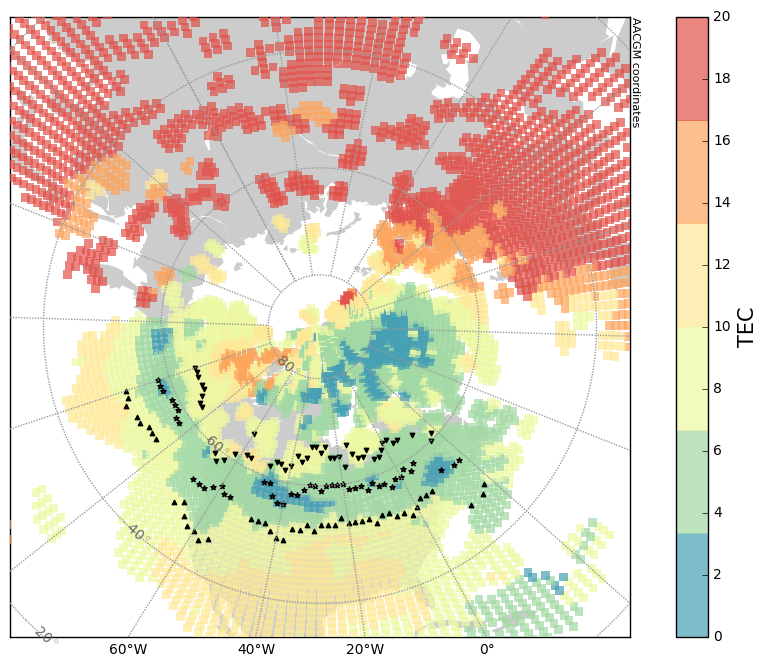

In [9]:
# set colorbar
seaMap = ListedColormap(sns.color_palette("Spectral_r"))
# flatui = ["#3182bd", "#9ecae1", "#7fcdbb", "#ffeda0", "#feb24c", "#f03b20"]
# sns.set_palette(flatui)
# seaMap = ListedColormap( sns.color_palette() )
# Plot map
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)
m1 = utils.plotUtils.mapObj(boundinglat=30., gridLabels=True, coords=anlyzCoords, ax=ax, datetime=selDT)
xVec, yVec = m1(list(selTecDF["Mlon"]), list(selTecDF["Mlat"]), coords=anlyzCoords)
# BND data
if trghBndDF is not None:
    xVecEquBnd, yVecEquBnd = m1(list(trghBndDF["BndMlon"]), list(trghBndDF["BndEquMlat"]), coords="mag")
    xVecPolBnd, yVecPolBnd = m1(list(trghBndDF["BndMlon"]), list(trghBndDF["BndPolMlat"]), coords="mag")
    xVecMinTrghBnd, yVecMinTrghBnd = m1(list(trghBndDF["BndMlon"]), list(trghBndDF["minTecMlat"]), coords="mag")
tecPlot = m1.scatter( xVec, yVec , c=selTecDF["med_tec"], s=40.,\
           cmap=seaMap, alpha=0.7, zorder=5., \
                     edgecolor='none', marker="s", vmin=0., vmax=20. )
if trghBndDF is not None:
    eqPlot = m1.scatter( xVecEquBnd, yVecEquBnd , s=10.,\
                         c='k', marker="^", zorder=7. )
    poPlot = m1.scatter( xVecPolBnd, yVecPolBnd , s=10.,\
                         c='k', marker="v", zorder=7. )
    mtPlot = m1.scatter( xVecMinTrghBnd, yVecMinTrghBnd , s=15.,\
                         c='r', marker="*", zorder=7. )

cbar = plt.colorbar(tecPlot, orientation='vertical')
cbar.set_label('TEC', size=15)

6.9 52.0 51.5646813958 52.5999601039


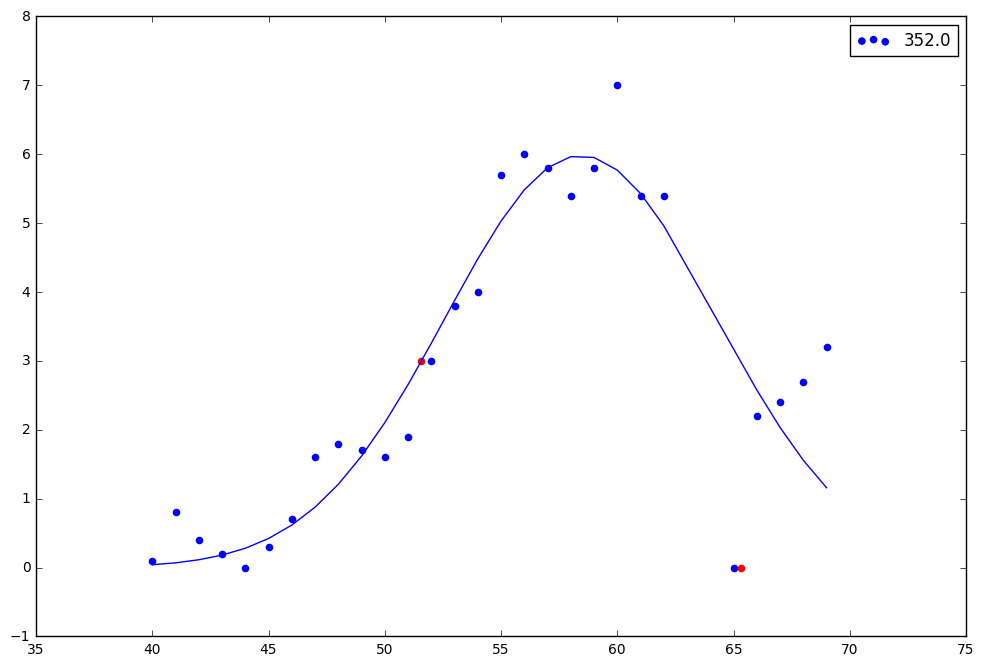

In [10]:
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)
colorList = [ "b", "r", "k" ]
# selMlonList = [ 260., 280., 300., 320., 340., 0., 18. ]
selMlonList = [ 352. ]
for ind, sMlon in enumerate(selMlonList):
    if sMlon < 0.:
        sMlon = sMlon + 360.
    selMlonDF = selTecDF[ (selTecDF["Mlon"] == sMlon) &\
                          (selTecDF["Mlat"] >= equTrghCutoffMLat) &\
                          (selTecDF["Mlat"] <= polTrghCutoffMLat)]
    # If no significant number of values are found discard
    if len( selMlonDF["med_tec"].values ) < 5.:
        continue
    tecGaussFitArr = numpy.max( selMlonDF["med_tec"].values ) - selMlonDF["med_tec"].values
    mlatPltArr = numpy.arange(equTrghCutoffMLat-20, polTrghCutoffMLat+20)
    popt, pcov = curve_fit(gauss_function, selMlonDF["Mlat"].values,\
                           tecGaussFitArr, p0 = [2, 52., 1.])
    fwhmEqu = popt[1] - popt[2]*2.355/2.
    fwhmPol = popt[1] + popt[2]*2.355/2.
    tecValFwhmEqu = gauss_function(fwhmEqu, *popt)
    tecValFwhmPol = gauss_function(fwhmPol, *popt)
    # Test goodness of fit
    ksTestTecArr = numpy.array( [ gauss_function(l, *popt)\
                                for l in selMlonDF["Mlat"].values.tolist() ] )
    ksDStat, ksPVal = stats.ks_2samp( tecGaussFitArr, ksTestTecArr )
    # we setup a few conditions to discard bad fits
    # 1) location of trough min should be between 45 nad 65 MLAT
    if ((popt[1] > cutOffTrghMinUpper)\
            | (popt[1] < cutOffTrghMinLower)):
        print "hey111"
        continue
    # 2) if percent error in any of fit parameters is more 
    # than 10 % (cutoff) then skip
    if ( ( pcov[0,0]**0.5/popt[0] > cutOffPrcntErrorFit  ) \
        | ( pcov[1,1]**0.5/popt[1] > cutOffPrcntErrorFit  ) \
        | ( pcov[2,2]**0.5/popt[2] > cutOffPrcntErrorFit  ) ):
        print "hey111222"
        continue
    # 3) Number of latitudes should be greater than 20.
    if len( selMlonDF["Mlat"].values ) < cutOffLatCnt:
        print "hey333"
        continue
    # 4) If p-val from the KS TEST is low discard
    # or if KS Stat is high discard
    if ksPVal < cutoffKSPval:
        print "hey444"
        continue
    if ksDStat > cutoffKSDstat:
        print "hey111444bbb"
        continue
    # 5) if tec value at min trough is greater than 4.
    # discard
    # GET Trough min loc and tec val
    minTrghLoc = min(list(selMlonDF["Mlat"].values), key=lambda x:abs(x-popt[1]))
    minTrghTecVal = selMlonDF[ selMlonDF["Mlat"] == minTrghLoc ]["med_tec"].values[0]
    # GET Trough equ loc and tec val
    equTrghLoc = min(list(selMlonDF["Mlat"].values), key=lambda x:abs(x-fwhmEqu))
    equTrghTecVal = selMlonDF[ selMlonDF["Mlat"] == equTrghLoc ]["med_tec"].values[0]
    print equTrghTecVal, equTrghLoc, fwhmEqu, popt[1]-popt[2]
    # GET Trough pol loc and tec val
    polTrghLoc = min(list(selMlonDF["Mlat"].values), key=lambda x:abs(x-fwhmPol))
    polTrghTecVal = selMlonDF[ selMlonDF["Mlat"] == polTrghLoc ]["med_tec"].values[0]
#     if minTrghTecVal > cutOffMinTECVal:
#         print minTrghTecVal
#         print "hey555"
#         continue
            
    ax.scatter( selMlonDF["Mlat"].values, tecGaussFitArr,label=str(sMlon), color=colorList[ind] )
    ax.plot( selMlonDF["Mlat"].values, ksTestTecArr )
    ax.scatter( popt[1] - popt[2]*2.355/2., numpy.max( selMlonDF["med_tec"].values )-equTrghTecVal, color="r" )
    ax.scatter( popt[1] + popt[2]*2.355/2., numpy.max( selMlonDF["med_tec"].values )-polTrghTecVal, color="r" )
ax.legend()


In [11]:
# To estimate the boundary we
# fit first order harmonics!
def trough_fit_harmonic(mlt, a0, c1, s1, phiC1, phiS1):
    phiC = (2*numpy.pi/24.) * mlt + phiC1
    phiS = (2*numpy.pi/24.) * mlt + phiS1
    cosTerm = c1 * numpy.cos(phiC)
    sinTerm = s1 * numpy.sin(phiS)
    return a0 + cosTerm + sinTerm

In [12]:
if trghBndDF is not None:
    poptMinTrgh, pcovMinTrgh = curve_fit( trough_fit_harmonic, trghBndDF["mlt"].values,\
                                   trghBndDF["minTecMlat"].values,\
                               p0 = [50, 1., 1., 1., 1.] )
    poptBndEqu, pcovBndEqu = curve_fit( trough_fit_harmonic, trghBndDF["mlt"].values,\
                                   trghBndDF["BndEquMlat"].values,\
                               p0 = [50, 1., 1., 1., 1.] )
    poptBndPol, pcovBndPol = curve_fit( trough_fit_harmonic, trghBndDF["mlt"].values,\
                                   trghBndDF["BndPolMlat"].values,\
                               p0 = [50, 1., 1., 1., 1.] )

    predMltArr = []
    predMlonArr = []
    predMinTECMlat = []
    predBndEquMlat = []
    predBndPolMlat = []

    for cpMlt in range(25):
        predMltArr.append( cpMlt )
        predMlonArr.append( round( convert_mlt( cpMlt,\
                                    selDT , m2a=True ) ) )
        predMinTECMlat.append( trough_fit_harmonic(\
                                    cpMlt, *poptMinTrgh) )
        predBndEquMlat.append( trough_fit_harmonic(\
                                    cpMlt, *poptBndEqu) )
        predBndPolMlat.append( trough_fit_harmonic(\
                                    cpMlt, *poptBndPol) )

    predTrghBndDF = pandas.DataFrame({
                    "predBndMlon" : predMlonArr,
                    "predBndEquMlat" : predBndEquMlat,
                    "predBndPolMlat" : predBndPolMlat,
                    "predMinTecMlat" : predMinTECMlat,
                    "predMLT" : predMltArr
                    })

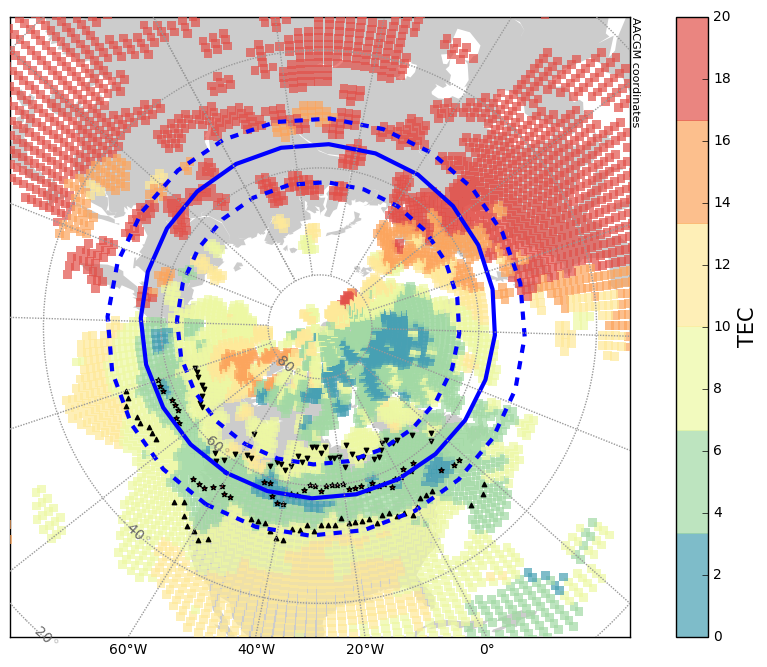

In [13]:
# set colorbar
seaMap = ListedColormap(sns.color_palette("Spectral_r"))
# flatui = ["#3182bd", "#9ecae1", "#7fcdbb", "#ffeda0", "#feb24c", "#f03b20"]
# sns.set_palette(flatui)
# seaMap = ListedColormap( sns.color_palette() )
# Plot map
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)
m1 = utils.plotUtils.mapObj(boundinglat=30., gridLabels=True, coords=anlyzCoords, ax=ax, datetime=selDT)
xVec, yVec = m1(list(selTecDF["Mlon"]), list(selTecDF["Mlat"]), coords=anlyzCoords)
# BND data
if trghBndDF is not None:
    xVecEquBnd, yVecEquBnd = m1(list(trghBndDF["BndMlon"]), list(trghBndDF["BndEquMlat"]), coords="mag")
    xVecPolBnd, yVecPolBnd = m1(list(trghBndDF["BndMlon"]), list(trghBndDF["BndPolMlat"]), coords="mag")
    xVecMinTrghBnd, yVecMinTrghBnd = m1(list(trghBndDF["BndMlon"]), list(trghBndDF["minTecMlat"]), coords="mag")
    # Pred locations
    xVecPredMinTrghBnd, yVecPredMinTrghBnd = m1(list(predTrghBndDF["predBndMlon"]),\
                                                list(predTrghBndDF["predMinTecMlat"]),\
                                                coords="mag")
    xVecPredEquBnd, yVecPredEquBnd = m1(list(predTrghBndDF["predBndMlon"]),\
                                                list(predTrghBndDF["predBndEquMlat"]),\
                                                coords="mag")
    xVecPredPolBnd, yVecPredPolBnd = m1(list(predTrghBndDF["predBndMlon"]),\
                                                list(predTrghBndDF["predBndPolMlat"]),\
                                                coords="mag")
    tecPlot = m1.scatter( xVec, yVec , c=selTecDF["med_tec"], s=40.,\
               cmap=seaMap, alpha=0.7, zorder=5., \
                         edgecolor='none', marker="s", vmin=0., vmax=20. )
    
    predMinTrghPlot = m1.plot( xVecPredMinTrghBnd, yVecPredMinTrghBnd,\
                              "b-", zorder=7., linewidth=3 )
    predEquBndPlot = m1.plot( xVecPredEquBnd, yVecPredEquBnd,\
                              "b--", zorder=7., linewidth=3 )
    predPolBndPlot = m1.plot( xVecPredPolBnd, yVecPredPolBnd,\
                              "b--", zorder=7., linewidth=3 )
    eqPlot = m1.scatter( xVecEquBnd, yVecEquBnd , s=10.,\
                         c='k', marker="^", zorder=7. )
    poPlot = m1.scatter( xVecPolBnd, yVecPolBnd , s=10.,\
                         c='k', marker="v", zorder=7. )
    mtPlot = m1.scatter( xVecMinTrghBnd, yVecMinTrghBnd , s=15.,\
                         c='r', marker="*", zorder=7. )
cbar = plt.colorbar(tecPlot, orientation='vertical')
cbar.set_label('TEC', size=15)